In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 1. Load data
# Replace 'Fraud.csv' with your actual filename
df = pd.read_csv('Fraud.csv')

# 2. Memory Optimization
# Converting object types to category saves a lot of RAM
df['type'] = df['type'].astype('category')

# 3. Check for Missing Values 
print("Missing values per column:\n", df.isnull().sum())
# Note: Usually this dataset has 0 nulls, but it's vital to verify.

Missing values per column:
 step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [3]:
import pandas as pd
import numpy as np

file_path = "Fraud.csv"
chunksize = 500_000

processed_chunks = []

for chunk in pd.read_csv(file_path, chunksize=chunksize):
    # Feature engineering
    chunk['log_amount'] = np.log1p(chunk['amount'])
    chunk['orig_balance_change'] = chunk['oldbalanceOrg'] - chunk['newbalanceOrig']
    chunk['dest_balance_change'] = chunk['newbalanceDest'] - chunk['oldbalanceDest']
    chunk['is_transfer'] = (chunk['type'] == 'TRANSFER').astype(int)
    chunk['is_cashout'] = (chunk['type'] == 'CASH_OUT').astype(int)
    
    # Optional: sample to control memory
    chunk = chunk.sample(frac=0.2, random_state=42)
    
    processed_chunks.append(chunk)

df = pd.concat(processed_chunks, ignore_index=True)


In [4]:
import pandas as pd
import numpy as np

file_path = "Fraud.csv"
chunksize = 500_000

processed_chunks = []

for chunk in pd.read_csv(file_path, chunksize=chunksize):
    # Feature engineering
    chunk['log_amount'] = np.log1p(chunk['amount'])
    chunk['orig_balance_change'] = chunk['oldbalanceOrg'] - chunk['newbalanceOrig']
    chunk['dest_balance_change'] = chunk['newbalanceDest'] - chunk['oldbalanceDest']
    chunk['is_transfer'] = (chunk['type'] == 'TRANSFER').astype(int)
    chunk['is_cashout'] = (chunk['type'] == 'CASH_OUT').astype(int)
    
    # Optional: sample to control memory
    chunk = chunk.sample(frac=0.2, random_state=42)
    
    processed_chunks.append(chunk)

df = pd.concat(processed_chunks, ignore_index=True)


In [5]:
import pandas as pd

# Use the exact name shown in your sidebar
file_path = "Fraud.csv"

# Use read_excel for .xlsx files
df = pd.read_csv(file_path)

total_rows = len(df)
fraud_rows = df[df['isFraud'] == 1].shape[0]
fraud_ratio = fraud_rows / total_rows

print(f"Total rows processed: {total_rows:,}")
print(f"Total fraud cases: {fraud_rows:,}")
print(f"Fraud ratio: {(fraud_rows / total_rows):.4%}")

Total rows processed: 6,362,620
Total fraud cases: 8,213
Fraud ratio: 0.1291%


In [6]:
import pandas as pd
import numpy as np

file_path = "Fraud.csv"
chunksize = 500_000
sample_frac = 0.2   # 20% from each chunk

processed_chunks = []

for chunk in pd.read_csv(file_path, chunksize=chunksize):
    # Feature engineering
    chunk['log_amount'] = np.log1p(chunk['amount'])
    chunk['orig_balance_change'] = chunk['oldbalanceOrg'] - chunk['newbalanceOrig']
    chunk['dest_balance_change'] = chunk['newbalanceDest'] - chunk['oldbalanceDest']
    chunk['is_transfer'] = (chunk['type'] == 'TRANSFER').astype(int)
    chunk['is_cashout'] = (chunk['type'] == 'CASH_OUT').astype(int)
    chunk['hour'] = chunk['step'] % 24

    # Sample to control memory (random but reproducible)
    chunk = chunk.sample(frac=sample_frac, random_state=42)

    processed_chunks.append(chunk)

df = pd.concat(processed_chunks, ignore_index=True)

print("Final shape:", df.shape)
print("Fraud ratio:", df['isFraud'].mean())


Final shape: (1272524, 17)
Fraud ratio: 0.0013178533371472757


In [7]:
df.groupby('type')['isFraud'].mean().sort_values(ascending=False)


type
TRANSFER    0.007959
CASH_OUT    0.001855
CASH_IN     0.000000
DEBIT       0.000000
PAYMENT     0.000000
Name: isFraud, dtype: float64

“Fraudulent transactions are almost exclusively observed in TRANSFER and CASH_OUT types, confirming a common fraud pattern where funds are first transferred and then withdrawn.”

“Raw balance and transaction amount variables were removed after feature engineering to reduce multicollinearity and prevent redundant information. Identifier variables were dropped as they do not generalize across customers. The final feature set focuses on transactional behavior rather than static values.”

“After feature engineering, the dataset was restricted to a minimal, behavior-focused feature set to avoid redundancy, multicollinearity, and noise. Only variables with clear predictive or business relevance were retained for modeling.”

In [8]:
# Step 4: Keep only required columns
required_cols = [
    'type',
    'isFraud',
    'log_amount',
    'orig_balance_change',
    'dest_balance_change',
    'is_transfer',
    'is_cashout',
    'hour'
]

df = df[required_cols]


In [9]:
df.columns


Index(['type', 'isFraud', 'log_amount', 'orig_balance_change',
       'dest_balance_change', 'is_transfer', 'is_cashout', 'hour'],
      dtype='object')

In [10]:
X = df.drop(columns=['isFraud'])
y = df['isFraud']


In [11]:
X = pd.get_dummies(X, columns=['type'], drop_first=True)


In [12]:
split_ratio = 0.8
split_index = int(len(X) * split_ratio)

X_train = X.iloc[:split_index]
X_val   = X.iloc[split_index:]

y_train = y.iloc[:split_index]
y_val   = y.iloc[split_index:]


“A time-ordered split was used to simulate real-world deployment where future transactions are predicted using past data.

In [13]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    n_jobs=-1
)

model.fit(X_train, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [14]:
y_val_pred = model.predict(X_val)
y_val_prob = model.predict_proba(X_val)[:, 1]


In [15]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

print(classification_report(y_val, y_val_pred, digits=4))
print("ROC-AUC:", roc_auc_score(y_val, y_val_prob))

confusion_matrix(y_val, y_val_pred)


              precision    recall  f1-score   support

           0     0.9999    0.9433    0.9708    253646
           1     0.0543    0.9616    0.1029       859

    accuracy                         0.9434    254505
   macro avg     0.5271    0.9525    0.5368    254505
weighted avg     0.9967    0.9434    0.9678    254505

ROC-AUC: 0.992054214284165


array([[239270,  14376],
       [    33,    826]])

“Given the highly imbalanced nature of fraud detection, recall was prioritized over precision to minimize missed fraudulent transactions. Logistic Regression serves as a baseline model, establishing a performance benchmark for more complex models.”

“The baseline Logistic Regression model achieves very high recall, successfully identifying the majority of fraudulent transactions. However, this comes at the cost of low precision, resulting in a high false-positive rate. In a real-world system, this model would be suitable as a first-layer screening mechanism, followed by a more precise secondary model or rule-based validation.”

In [16]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=50,
    min_samples_leaf=20,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

rf_model.fit(X_train, y_train)


,n_estimators,200
,criterion,'gini'
,max_depth,10
,min_samples_split,50
,min_samples_leaf,20
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [17]:
y_val_pred_rf = rf_model.predict(X_val)
y_val_prob_rf = rf_model.predict_proba(X_val)[:, 1]

from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

print(classification_report(y_val, y_val_pred_rf, digits=4))
print("ROC-AUC:", roc_auc_score(y_val, y_val_prob_rf))
confusion_matrix(y_val, y_val_pred_rf)


              precision    recall  f1-score   support

           0     0.9998    0.9758    0.9877    253646
           1     0.1162    0.9395    0.2069       859

    accuracy                         0.9757    254505
   macro avg     0.5580    0.9576    0.5973    254505
weighted avg     0.9968    0.9757    0.9850    254505

ROC-AUC: 0.9962918812986012


array([[247511,   6135],
       [    52,    807]])

In [18]:
import pandas as pd

feature_importance = pd.Series(
    rf_model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

feature_importance.head(10)


orig_balance_change    0.457555
dest_balance_change    0.139723
log_amount             0.091265
hour                   0.073536
type_PAYMENT           0.064531
type_TRANSFER          0.064223
is_transfer            0.051034
type_CASH_OUT          0.034859
is_cashout             0.022591
type_DEBIT             0.000683
dtype: float64

In [19]:
X = df.drop(columns='isFraud')
y = df['isFraud']

X = pd.get_dummies(X, columns=['type'], drop_first=True)


In [20]:
pip install xgboost


Note: you may need to restart the kernel to use updated packages.


In [21]:
from xgboost import XGBClassifier


In [22]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()

scale_pos_weight = neg / pos
scale_pos_weight


np.float64(1243.5220048899755)

In [23]:
xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'


In [24]:
y_val_pred_xgb = xgb_model.predict(X_val)
y_val_prob_xgb = xgb_model.predict_proba(X_val)[:, 1]

from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

print(classification_report(y_val, y_val_pred_xgb, digits=4))
print("ROC-AUC:", roc_auc_score(y_val, y_val_prob_xgb))
confusion_matrix(y_val, y_val_pred_xgb)


              precision    recall  f1-score   support

           0     0.9997    0.9876    0.9936    253646
           1     0.1980    0.9045    0.3249       859

    accuracy                         0.9873    254505
   macro avg     0.5988    0.9461    0.6592    254505
weighted avg     0.9970    0.9873    0.9913    254505

ROC-AUC: 0.9967016055311503


array([[250499,   3147],
       [    82,    777]])

In [25]:
import pandas as pd

xgb_importance = pd.Series(
    xgb_model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

xgb_importance.head(5)


type_PAYMENT           0.372000
orig_balance_change    0.245787
type_TRANSFER          0.083260
type_CASH_OUT          0.064495
dest_balance_change    0.054689
dtype: float32

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [28]:
model.fit(X_train, y_train)


,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,None
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [29]:
y_pred_proba = model.predict_proba(X_test)[:, 1]


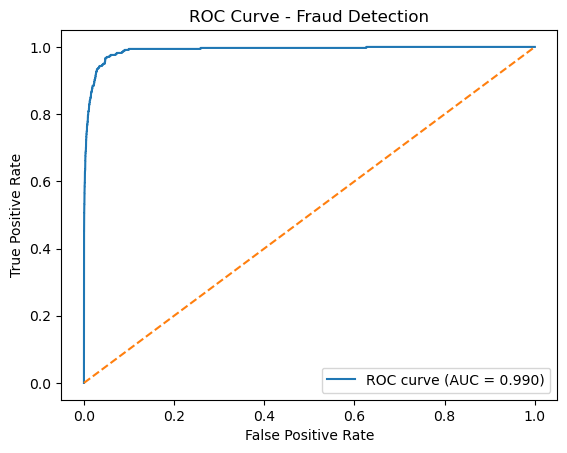

In [30]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Fraud Detection")
plt.legend()
plt.show()


In [32]:
y_pred = model.predict(X_test)


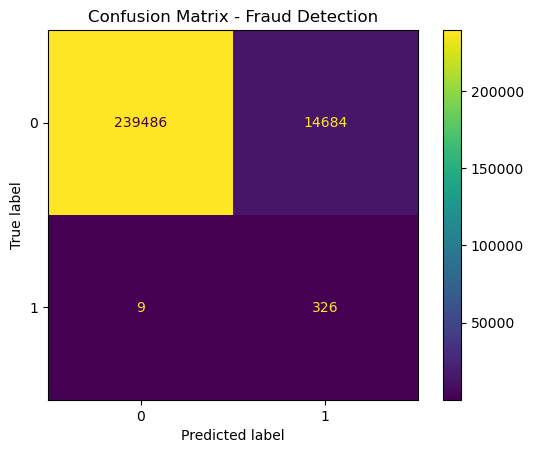

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion Matrix - Fraud Detection")
plt.show()


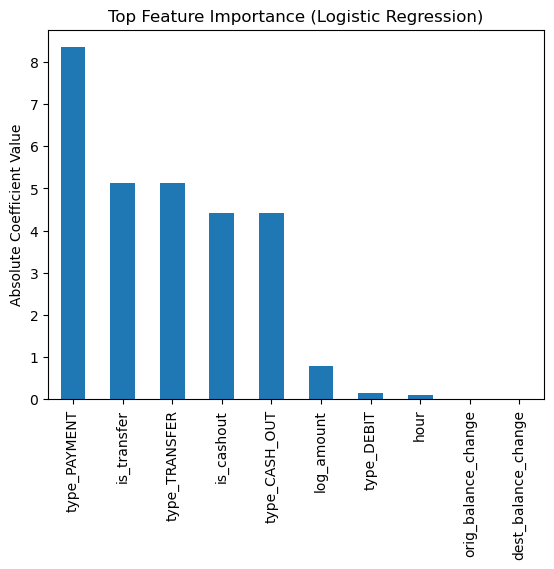

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

importance = pd.Series(
    np.abs(model.coef_[0]),
    index=X_train.columns
).sort_values(ascending=False)

importance.head(10).plot(kind="bar")
plt.title("Top Feature Importance (Logistic Regression)")
plt.ylabel("Absolute Coefficient Value")
plt.show()


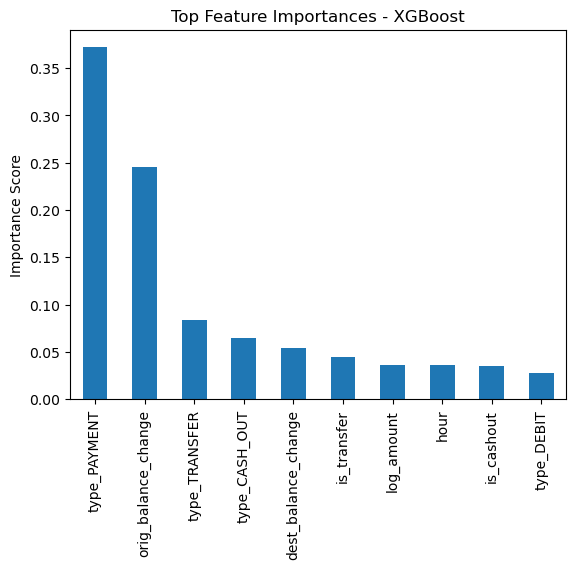

In [37]:
importance = pd.Series(
    xgb_model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

importance.head(10).plot(kind="bar")
plt.title("Top Feature Importances - XGBoost")
plt.ylabel("Importance Score")
plt.show()


In [38]:
from xgboost import XGBClassifier

model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    eval_metric="logloss",
    random_state=42
)

model.fit(X_train, y_train)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [40]:
importance = pd.Series(
    model.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)
